In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from lightgbm import LGBMClassifier, plot_importance
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_score, recall_score, f1_score
%matplotlib inline
sns.set_style()

In [330]:
# Reading in the data
df = pd.read_json('ultimate_data_challenge.json')

In [331]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [332]:
df.shape

(50000, 12)

In [333]:
# Finding the latest date in order to calculate active users
df['last_trip_date'].max()

'2014-07-01'

In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [335]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [336]:
# Changing the dates to datetime types
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [337]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [338]:
df.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [339]:
df['city'].nunique()

3

In [340]:
# Adding column to df indicating if each user is active
df['retained'] = (df['last_trip_date'] >= (max_date - np.timedelta64(30, 'D')))

In [341]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [342]:
# Finding the total number of users retained and total number not retained
df['retained'].value_counts()

False    31196
True     18804
Name: retained, dtype: int64

### The fraction/percent retained below is based on the number of customers who were active in the 30 days previous to the last date provided 

In [343]:
# Fraction_retained = 18804 / 31196
percent_retained = 18804 / 31196 * 100
print('Percent of active customers out of all customers is: ', round(percent_retained, 2))

Percent of active customers out of all customers is:  60.28


In [344]:
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

In [345]:
# Calculating the number of months each user is retained 
df['months_retained'] = (df['last_trip_date'] + np.timedelta64(30, 'D') - df['signup_date']) // np.timedelta64(1, 'M')

In [346]:
# Creating a boolean column distinguishing between those users retained for 6 months and those not
df['6months'] = df['months_retained'] == 6

In [347]:
# Dropping datetime-type data 
df.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   49604 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  int64  
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    49799 non-null  float64
 10  retained                50000 non-null  bool   
 11  months_retained         50000 non-null  int64  
 12  6months                 50000 non-null  bool   
dtypes: bool(2), float64(6), int64(3), object(2)
memory usage: 4.3+ MB


In [349]:
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,months_retained,6months
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,True,5,False
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,False,4,False
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,False,1,False
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,True,6,True
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,False,2,False


In [350]:
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [351]:
df.dtypes

city                       object
trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
phone                      object
surge_pct                 float64
ultimate_black_user         int64
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
retained                     bool
months_retained             int64
6months                      bool
dtype: object

/Users/butler/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:461: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Users/butler/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:462: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


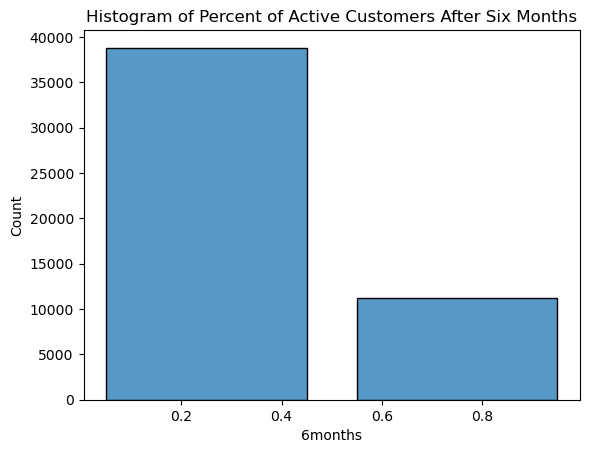

In [352]:
df['6months_plot'] = df['6months'].map({True: 'True', False: 'False'})
_ = sns.histplot(data=df, x='6months', bins=2, shrink=.8).set(title='Histogram of Percent of Active Customers After Six Months')

In [353]:
df.drop('6months_plot', axis=1, inplace=True)

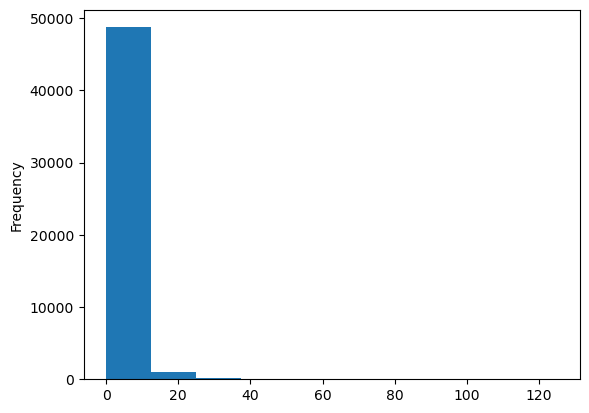

In [354]:
_ = df['trips_in_first_30_days'].plot.hist()

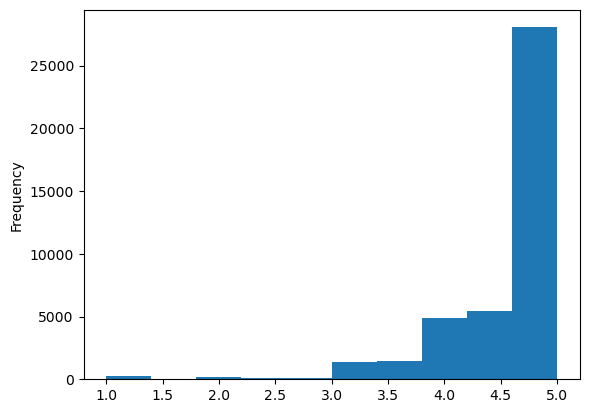

In [355]:
_= df['avg_rating_of_driver'].plot.hist()

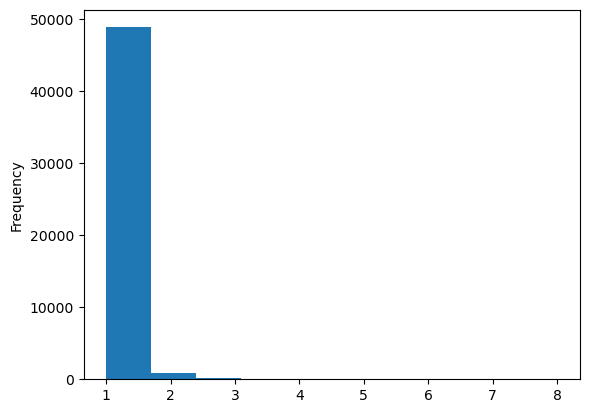

In [356]:
_= df['avg_surge'].plot.hist()

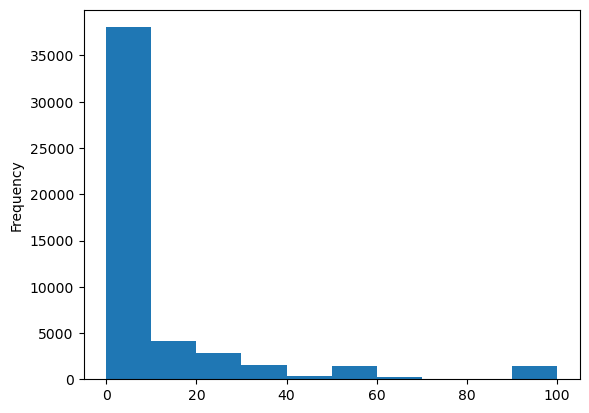

In [357]:
_= df['surge_pct'].plot.hist()

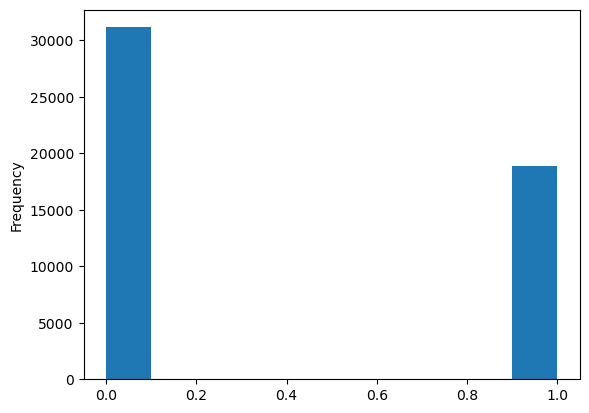

In [358]:
_= df['ultimate_black_user'].plot.hist()

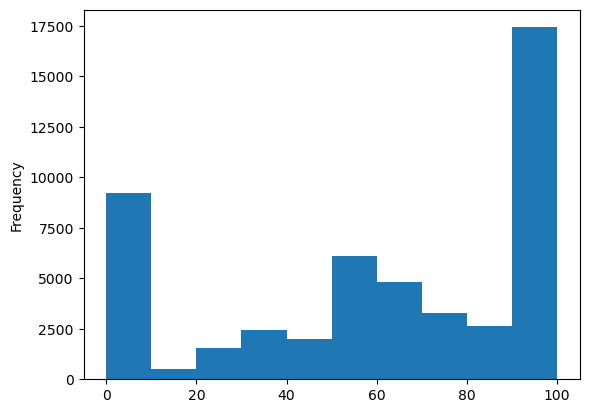

In [359]:
_= df['weekday_pct'].plot.hist()

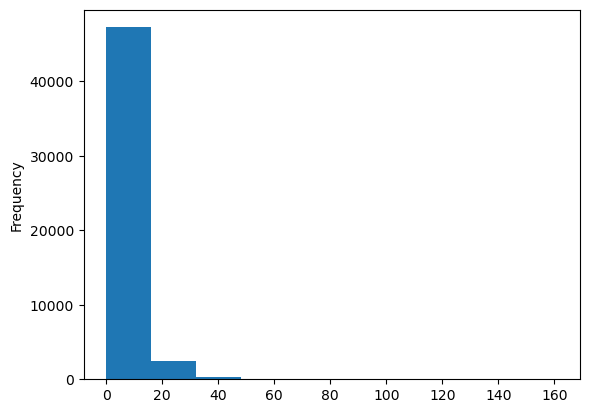

In [360]:
_= df['avg_dist'].plot.hist()

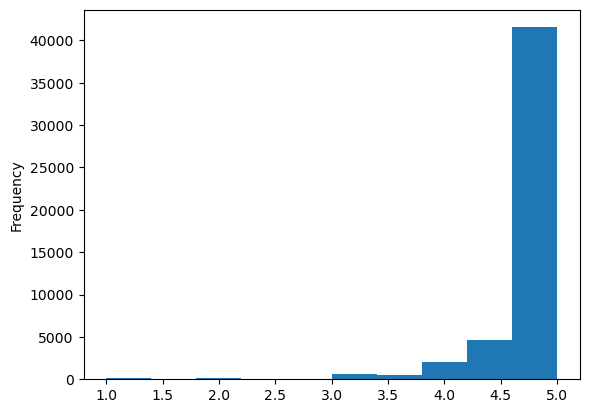

In [361]:
_= df['avg_rating_by_driver'].plot.hist()

In [362]:
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,months_retained,6months
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,True,5,False
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,False,4,False
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,False,1,False
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,True,6,True
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,False,2,False


In [363]:
df.tail()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,months_retained,6months
49995,King's Landing,0,5.0,1.0,iPhone,0.0,0,100.0,5.63,4.2,True,5,False
49996,Astapor,1,NaN,1.0,iPhone,0.0,0,0.0,0.00,4.0,False,1,False
49997,Winterfell,0,5.0,1.0,Android,0.0,1,100.0,3.86,5.0,False,4,False
49998,Astapor,2,3.0,1.0,iPhone,0.0,0,100.0,4.58,3.5,False,1,False
49999,Astapor,0,NaN,1.0,Android,0.0,0,0.0,3.49,5.0,False,4,False


In [364]:
# Dropping retained and months retained because these column are just a calculation based on the other columns
df.drop(['retained', 'months_retained'], axis=1, inplace=True)

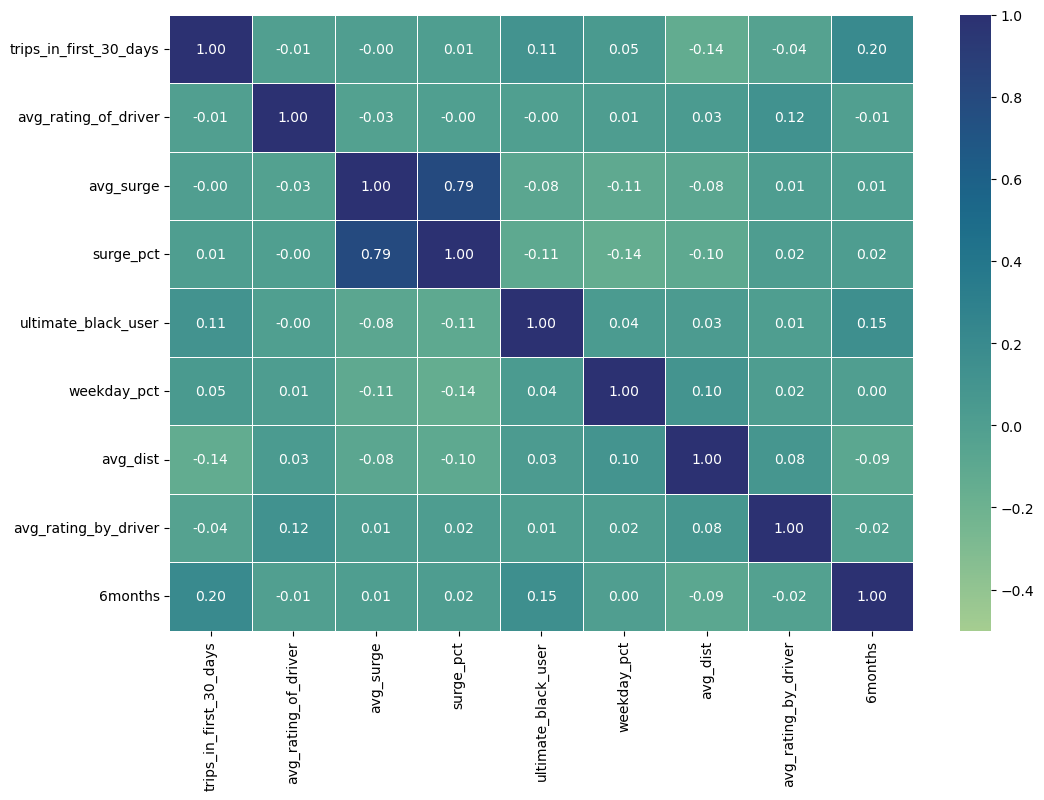

In [365]:
# Plotting heatmap
f, ax = plt.subplots(figsize=(12, 8))
_ = sns.heatmap(data=df.corr(numeric_only=True), vmin=-.5, vmax=1, annot=True, fmt='.2f', linewidth=.5, cmap='crest', )

In [366]:
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,6months
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,False
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,False
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,False
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,True
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,False


In [367]:
# One-hot encoding city column
enc_city = pd.get_dummies(df['city'])
df = df.join(enc_city).drop('city', axis=1)

In [368]:
X = df.drop('6months', axis=1)
y = df['6months']

In [369]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [370]:
X_train.phone.value_counts()

iPhone     27663
Android    12011
Name: phone, dtype: int64

In [371]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 7540 to 30954
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  40000 non-null  int64  
 1   avg_rating_of_driver    33498 non-null  float64
 2   avg_surge               40000 non-null  float64
 3   phone                   39674 non-null  object 
 4   surge_pct               40000 non-null  float64
 5   ultimate_black_user     40000 non-null  int64  
 6   weekday_pct             40000 non-null  float64
 7   avg_dist                40000 non-null  float64
 8   avg_rating_by_driver    39839 non-null  float64
 9   Astapor                 40000 non-null  uint8  
 10  King's Landing          40000 non-null  uint8  
 11  Winterfell              40000 non-null  uint8  
dtypes: float64(6), int64(2), object(1), uint8(3)
memory usage: 3.2+ MB


In [372]:
X_train['phone'].value_counts()

iPhone     27663
Android    12011
Name: phone, dtype: int64

In [373]:
# Filling missing values of phone with the more common one
X_train.phone = X_train.phone.fillna('iPhone')

In [374]:
X_test.phone.value_counts()

iPhone     6919
Android    3011
Name: phone, dtype: int64

In [375]:
# Filling missing values of phone with the more common one
X_test.phone = X_test.phone.fillna('iPhone')

In [376]:
# One-hot encoding phone column for X_train
enc_phone = pd.get_dummies(X_train['phone'])
X_train = X_train.join(enc_phone).drop('phone', axis=1)

In [377]:
# One-hot encoding phone column for X_test
enc_phone = pd.get_dummies(X_test['phone'])
X_test = X_test.join(enc_phone).drop('phone', axis=1)

In [378]:
# Filling missing values in X_train of avg_rating_of_driver and avg_rating_by_driver with each column's mean
mean = X_train.avg_rating_of_driver.mean()
X_train.avg_rating_of_driver = X_train.avg_rating_of_driver.fillna(mean)
mean2 = X_train.avg_rating_of_driver.mean()
X_train.avg_rating_of_driver = X_train.avg_rating_by_driver.fillna(mean2)

In [379]:
# Filling missing values in X_test of avg_rating_of_driver and avg_rating_by_driver with each column's mean
mean = X_test.avg_rating_of_driver.mean()
X_test.avg_rating_of_driver = X_test.avg_rating_of_driver.fillna(mean)
mean2 = X_test.avg_rating_of_driver.mean()
X_test.avg_rating_of_driver = X_test.avg_rating_by_driver.fillna(mean2)

In [380]:
X_train.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,iPhone
7540,0,5.0,1.00,0.0,1,33.3,1.49,5.0,0,0,1,0,1
29754,5,4.2,1.00,0.0,1,0.0,2.71,4.2,0,0,1,0,1
39998,1,5.0,1.00,0.0,1,100.0,2.34,5.0,1,0,0,0,1
2461,1,3.0,1.00,0.0,0,100.0,2.07,3.0,1,0,0,1,0
3024,1,5.0,2.25,100.0,0,100.0,3.23,5.0,1,0,0,1,0


In [381]:
# Using light gradient-boosting machine to model data
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [382]:
# Using the model's results to predict the y values of the test data
y_pred = lgbm.predict(X_test)

In [383]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.93      0.88      7781
        True       0.61      0.39      0.47      2219

    accuracy                           0.81     10000
   macro avg       0.72      0.66      0.68     10000
weighted avg       0.79      0.81      0.79     10000



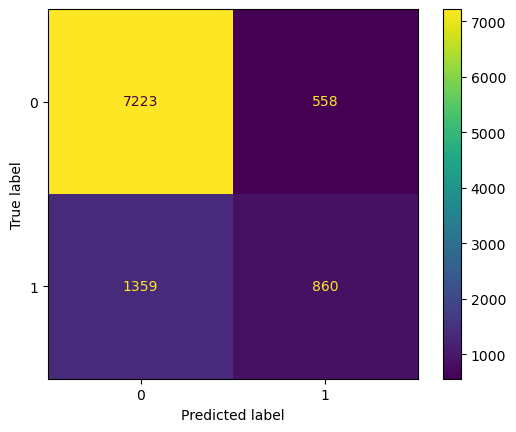

In [384]:
cm = confusion_matrix(y_test, y_pred)

_ = ConfusionMatrixDisplay(cm).plot()

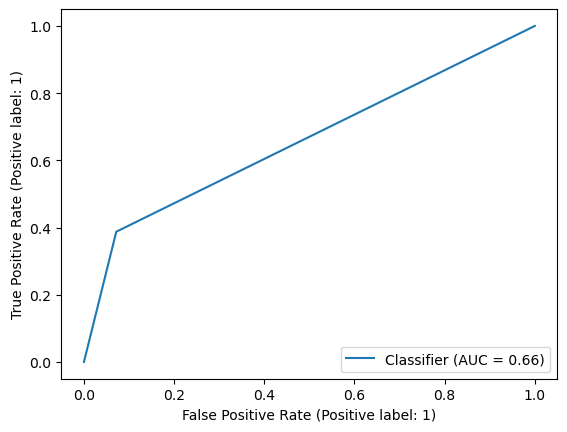

In [385]:
_ = RocCurveDisplay.from_predictions(y_test, y_pred)

In [386]:
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'f1: {f1_score(y_test, y_pred)}')

Recall: 0.3875619648490311
Precision: 0.6064880112834978
f1: 0.4729172394830904


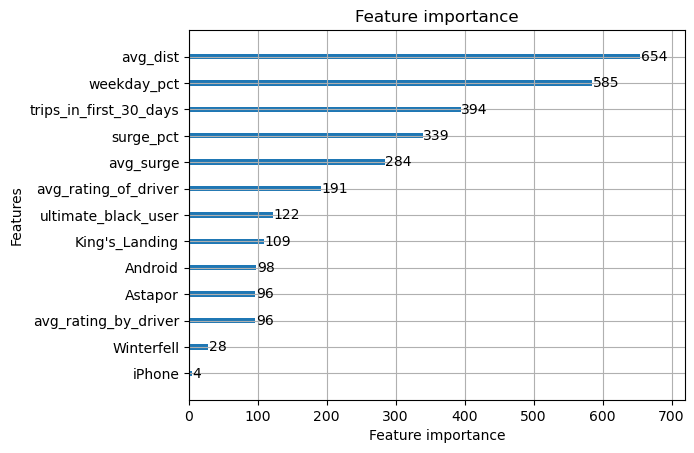

In [387]:
# Getting feature importances
_ = plot_importance(lgbm)